## CA3

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say **`YOUR CODE HERE`**.

- You will need to use GPU, which can be added through
`Edit > Notebook Settings > Hardware accelerator > (GPU)`

- For text-based answers, you should replace the text that says **`Write your answer here...`** with your actual answer.

- This assignment is designed such that each cell takes a few minutes (if that) to run. If it is taking longer than that, you might have made a mistake in your code.

---

##### *How to submit this problem set:*
- Write all the answers in this Colab notebook. Once you are finished, generate a PDF via (File -> Print -> Save as PDF) and upload it to Gradescope.
  
- **Important:** check your PDF before you submit to Gradescope to make sure it exported correctly. If Colab gets confused about your syntax, it will sometimes terminate the PDF creation routine early.

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. One handy way to do this is by clicking `Runtime -> Run All` in the notebook menu.

# Part 0: Setup

## Installing Hugging Face's Transformers and Additional Libraries
We will use Hugging Face's Transformers (https://github.com/huggingface/transformers), an open-source library that provides general-purpose architectures for natural language understanding and generation with a collection of various pretrained models made by the NLP community. This library will allow us to easily use pretrained models like `BERT` and perform experiments on top of them. We can use these models to solve downstream target tasks, such as text classification, question answering, sequence labeling, and text generation.

Run the following cell to install Hugging Face's Transformers library and some other useful tools. This cell will also download data used later in the assignment.

In [1]:
!pip3 install -U accelerate
!pip install -q -U transformers==4.17.0 datasets==2.0.0 rich[jupyter]
!pip3 install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ea232c559fc2b74d950c1b3c845b5404c2ab2131347752aa642c513637734fc3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


## Import Necessary Libraries

In [2]:
import torch
from torch.utils.data import (
    Dataset, DataLoader
)
from transformers import (
    GPT2LMHeadModel, GPT2Tokenizer,
    BartTokenizerFast, BartForConditionalGeneration,
    TrainingArguments, Trainer
)
from transformers.optimization import AdamW
from datasets import (
    load_dataset, load_metric
)

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Part 1. Beam Search
We're going to explore decoding from a pretrained GPT-2 model using beam search. Run the below cell to set up some beam search utilities.

In [3]:
def init_beam_search(model, input_ids, num_beams):
    assert len(input_ids.shape) == 2
    beam_scores = torch.zeros(num_beams, dtype=torch.float32, device=model.device)
    beam_scores[1:] = -1e9 # Break ties in first round.
    new_input_ids = input_ids.repeat_interleave(num_beams, dim=0).to(model.device)
    return new_input_ids, beam_scores

def run_beam_search_(model, tokenizer, input_text, num_beams=5, num_decode_steps=10, score_processors=[], to_cpu=True):

    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    input_ids, beam_scores = init_beam_search(model, input_ids, num_beams)
    token_scores = beam_scores.clone().view(num_beams, 1)

    model_kwargs = {}
    for i in range(num_decode_steps):
        model_inputs = model.prepare_inputs_for_generation(input_ids, **model_kwargs)
        outputs = model(**model_inputs, return_dict=True)
        next_token_logits = outputs.logits[:, -1, :]
        vocab_size = next_token_logits.shape[-1]
        this_token_scores = torch.log_softmax(next_token_logits, -1)

        # Process token scores.
        processed_token_scores = this_token_scores
        for processor in score_processors:
            processed_token_scores = processor(input_ids, processed_token_scores)

        # Update beam scores.
        next_token_scores = processed_token_scores + beam_scores.unsqueeze(-1)
        next_token_scores = next_token_scores.view(num_beams * vocab_size)

        # Find top-scoring beams.
        next_token_scores, next_tokens = torch.topk(
            next_token_scores, num_beams, dim=0, largest=True, sorted=True
        )

        # Transform tokens since we reshaped earlier.
        next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor") # This is equivalent to `next_tokens // vocab_size`
        next_tokens = next_tokens % vocab_size

        # Update tokens and beam scores.
        input_ids = torch.cat([input_ids[next_indices, :], next_tokens.unsqueeze(-1)], dim=-1)
        beam_scores = next_token_scores

        # UNCOMMENT: To use original scores instead.
        # token_scores = torch.cat([token_scores[next_indices, :], this_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)
        token_scores = torch.cat([token_scores[next_indices, :], processed_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)

        # Update hidden state.
        model_kwargs = model._update_model_kwargs_for_generation(outputs, model_kwargs, is_encoder_decoder=False)
        model_kwargs["past"] = model._reorder_cache(model_kwargs["past"], next_indices)

    def transfer(x):
      return x.cpu() if to_cpu else x

    return {
        "output_ids": transfer(input_ids),
        "beam_scores": transfer(beam_scores),
        "token_scores": transfer(token_scores)
    }


def run_beam_search(*args, **kwargs):
    with torch.inference_mode():
        return run_beam_search_(*args, **kwargs)

Run the cell below. It produces a sequence of tokens using beam search and the provided prefix.

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

num_beams = 5
num_decode_steps = 10
input_text = 'The brown fox jumps'

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
for i, tokens in enumerate(beam_output['output_ids']):
    score = beam_output['beam_scores'][i]
    print(i, round(score.item() / tokens.shape[-1], 3), tokenizer.decode(tokens, skip_special_tokens=True))

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

0 -1.106 The brown fox jumps out of the fox's mouth, and the fox
1 -1.168 The brown fox jumps out of the fox's cage, and the fox
2 -1.182 The brown fox jumps out of the fox's mouth and starts to run
3 -1.192 The brown fox jumps out of the fox's mouth and begins to lick
4 -1.199 The brown fox jumps out of the fox's mouth and begins to bite


## Question 1.1

Write a code to investigate the probabilities that the model assigns to each generated word using beam size one (you can use visualizations or simply report the results).
Do the probabilities increase or decrease while more words are generated? Can you explain the reason?

**As we generate more words in the sequence, the initial probability, which is the score normalized by the number of tokens, tends to decrease. This is because the denominator, representing the number of tokens, keeps growing. It's like spreading the initial confidence thinner as more words join the mix.
On the other hand, the probabilities assigned to the following words can fluctuate. They might increase as the model becomes more certain and gains a better understanding of the context, making more accurate predictions for the next words in the sequence. So, while the initial confidence may diminish, the model refines its predictions and potentially becomes more certain about subsequent words.**

In [5]:
def generated_word_probability():
    # Import necessary libraries
    import torch
    from transformers import GPT2LMHeadModel, GPT2Tokenizer

    # Load pre-trained GPT-2 model and tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

    # Set beam size to one
    num_beams = 1
    num_decode_steps = 10
    input_text = 'The brown fox jumps'

    # Run beam search with a beam size of one
    beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)

    # Print probabilities for each generated word
    for i, tokens in enumerate(beam_output['output_ids']):
        score = beam_output['beam_scores'][i]

        # Calculate and print the probability for each generated word
        word_probabilities = [score.item() / tokens.shape[-1]]
        for j, token_id in enumerate(tokens[1:]):  # Skip the first token as it is the input token
            if j < len(beam_output['token_scores'][i]):
                word_probabilities.append(beam_output['token_scores'][i, j].item())

        print(f"Word Probabilities for Beam {i + 1}:", word_probabilities)

# Call the function
generated_word_probability()


Word Probabilities for Beam 1: [-1.334479604448591, 0.0, -1.6708067655563354, -0.9767038822174072, -1.7385754585266113, -1.923224925994873, -0.9448810815811157, -1.4814355373382568, -1.4341440200805664, -2.7090537548065186, -2.4500646591186523, -3.353825092315674]


## Question 1.2

Use higher beam size and compute the cumulative probability of each different sequence and report the results. Does a higher beam size always guarantee a higher probability for the final sequence? Why or why not?

**No, a higher beam size doesn't always guarantee a higher probability for the final sequence. While a larger beam size increases diversity in sequence generation, it introduces varied token probabilities, and the top-scoring tokens may not consistently contribute to a higher overall probability. The relationship between beam size and cumulative probability is complex and depends on the interplay of token probabilities and sequence diversity.**

In [6]:
from torch.distributions import Categorical

def compute_cumulative_probability(model, tokenizer, input_text, num_beams=5, num_decode_steps=10, score_processors=[], to_cpu=True):
    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    # Generate sequences
    sequences = model.generate(input_ids, num_beams=num_beams, max_length=num_decode_steps)

    # Apply score processors
    for processor in score_processors:
        sequences = processor(sequences)

    # Compute cumulative probabilities
    with torch.no_grad():
        outputs = model(sequences)
        logits = outputs.logits
        probs = Categorical(logits=logits).probs
        cumulative_probs = probs.log().exp().sum(-1)

    return cumulative_probs.tolist()


def generated_sequence_probability(model, tokenizer, input_text, higher_beam_size=10):
    # Compute cumulative probabilities for the higher beam size
    cumulative_probs_high_beam = compute_cumulative_probability(model, tokenizer, input_text, num_beams=higher_beam_size)

    # Print the results
    for i, prob in enumerate(cumulative_probs_high_beam):
        print(f"Sequence {i + 1}: Cumulative Probability - {[round(p, 6) for p in prob]}")

    # Compare with the original beam size
    cumulative_probs_low_beam = compute_cumulative_probability(model, tokenizer, input_text, num_beams=5)

    # Print the results
    print("\nComparison:")
    for i in range(len(cumulative_probs_low_beam)):
        print(f"Sequence {i + 1}: Low Beam - {[round(p, 6) for p in cumulative_probs_low_beam[i]]}, High Beam - {[round(p, 6) for p in cumulative_probs_high_beam[i]]}")

# Set up GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# Set parameters
higher_beam_size = 10
input_text = 'The brown fox jumps'

# Call the function
generated_sequence_probability(model, tokenizer, input_text, higher_beam_size=higher_beam_size)


Sequence 1: Cumulative Probability - [0.999999, 1.000002, 1.000004, 1.000014, 1.000024, 1.000018, 1.000008, 1.000017, 1.000017, 1.00001]

Comparison:
Sequence 1: Low Beam - [0.999999, 1.000002, 1.000004, 1.000014, 1.000024, 1.000018, 1.000008, 1.000017, 1.000017, 1.00001], High Beam - [0.999999, 1.000002, 1.000004, 1.000014, 1.000024, 1.000018, 1.000008, 1.000017, 1.000017, 1.00001]


## Question 1.3

Beam search often results in repetition in the predicted tokens. One way to prevent such repetitions is a technique called `Word Block`. At each time step, it reduces the probability for any previously seen word so that it is not generated again. What is the problem with this approach?

**Word Block, a technique in beam search to reduce token repetition, can lead to a problem by making the model overly conservative. Heavy penalization of previously seen words may restrict the model's creativity, potentially resulting in less diverse and contextually relevant outputs. Achieving the right balance in penalization is crucial to prevent unnecessary limitations on the model's language generation capabilities.**

## Question 1.4

Write a score processor called `BeamBlock`. This processor should prevent n-grams from appearing more than once in the sequence. Obviously, n should be an input argument. pass your score processesor to the `score_processors` argument of the `run_beam_search_` function.
Compare the result of generated sentences for `n = 1, 2, and 3` by running a beam search with beam size 1 for the following input text:

`input_text = 'Once upon a time, in a barn near a farm house,'`


In [ ]:
class BeamBlock:
    def __init__(self, n):
        self.n = n
        self.seen_ngrams = []

    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            # Get the sequence for the current batch
            sequence = input_ids[batch_idx].tolist()

            # Extract n-grams from the sequence
            ngrams = [tuple(sequence[i:i + self.n]) for i in range(len(sequence) - self.n + 1)]

            # Check for repeated n-grams and penalize the corresponding scores
            for ngram in ngrams:
                if ngram in self.seen_ngrams:
                    scores[batch_idx, -1] -= float('inf')  # Set score to negative infinity for repeated n-grams
                else:
                    self.seen_ngrams.append(ngram)

        return scores

input_text = 'Once upon a time, in a barn near a farm house'

# Run beam search with different n values
for n in [1, 2, 3]:
    beam_block_processor = BeamBlock(n)

    beam_output = run_beam_search_(
        model, tokenizer, input_text,
        num_beams=1, num_decode_steps=50,
        score_processors=[beam_block_processor]
    )

    # Print the generated sequence
    print(f"\nGenerated sequence for n = {n}:\n{tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True)}")



Generated sequence for n = 1:
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick

Generated sequence for n = 2:
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick

Generated sequence for n = 3:
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick


In [ ]:
del model
del tokenizer

# Part 2. Language Model Fine-tuning
Now, we'll switch over to *fine-tuning* a pretrained language model. For this task, we'll use data from the `CNN Dailymail Dataset` Available [here](https://huggingface.co/datasets/cnn_dailymail). The CNN DailyMail Dataset is an English dataset containing just over 300k unique news articles as written by journalists at CNN and the Daily Mail and can be used to train a model for abstractive and extractive summarization.

We are going to get familiar with coding frameworks to use or fine-tune pre-trained models. In some sections, you need to complete the codes in order to get the results.

In [ ]:
BATCH_SIZE = 8
MODEL_NAME = 'facebook/bart-base'

## Question 2.1
Load 10 percent of each of train/test/validation splits of the dataset.

In [ ]:
from datasets import load_dataset

# Load the CNN Dailymail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Get 10 percent of the dataset for each split
train_dataset = dataset["train"].shuffle(seed=42).select([i for i in range(len(dataset["train"]) // 10)])
test_dataset = dataset["test"].shuffle(seed=42).select([i for i in range(len(dataset["test"]) // 10)])
validation_dataset = dataset["validation"].shuffle(seed=42).select([i for i in range(len(dataset["validation"]) // 10)])

# Display the number of samples in each split
print(f"Number of samples in the train split: {len(train_dataset)}")
print(f"Number of samples in the test split: {len(test_dataset)}")
print(f"Number of samples in the validation split: {len(validation_dataset)}")


Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Number of samples in the train split: 28711
Number of samples in the test split: 1149
Number of samples in the validation split: 1336


## Question 2.2

We are going to use Pytorch `Dataset` and `DataLoader` classes to work with CNN Dailymail Dataset.
Complete the `__get_item__` function of the following class to encode and output samples of the dataset in a form usable by causal language models in the `transformers` library. Explain the necessary fields of the output dictionary.

**The fields in the returned dictionary are:**

*   `input_ids`: This field contains the tokenized input sequences. Each token is represented by a unique integer ID. The tokenization process involves converting the input text into a sequence of these integer IDs. The tokenizer object is used to perform this conversion. The input_ids are returned as a PyTorch tensor, which is a multi-dimensional matrix containing elements of a single data type.
*   `attention_mask`: This field is used to mask the input tokens in the
transformer model. It is a binary tensor indicating which tokens should be attended to by the model. The attention_mask is created in a way that the tokens that should be ignored (like padding tokens) are marked with 0s, and the tokens that should be attended to are marked with 1s.
*   `labels`: This field contains the tokenized label sequences. Similar to the input_ids, each token in the label sequence is represented by a unique integer ID. The labels are used to train the model to predict the next token in the sequence. The labels are also returned as a PyTorch tensor.

In [ ]:
from torch.utils.data import Dataset

class SampleDataset(Dataset):

    def __init__(
        self, tokenizer, inputs, labels,
        input_max_length=500, output_max_length=50
    ):
        self.inputs = inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.input_max_len = input_max_length
        self.output_max_len = output_max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Encode input and label sequences
        input_sequence = self.tokenizer(
            self.inputs[idx],
            max_length=self.input_max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        label_sequence = self.tokenizer(
            self.labels[idx],
            max_length=self.output_max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Get the tensors from the dictionary
        input_ids = input_sequence["input_ids"].squeeze()
        attention_mask = input_sequence["attention_mask"].squeeze()
        labels = label_sequence["input_ids"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


## Question 2.3

We are using Bart for being fine-tuned on CNN Dailymail Dataset. Give a breif summary of the structure of this model. Compare its architecture with GPT-2.

****BART (BART architecture):**
- **Structure:** Encoder-decoder architecture.
- **Objective:** Denoising autoencoder, reconstructs corrupted input.
- **Components:** Bidirectional attention in both encoder and decoder.

**GPT-2 (GPT-2 architecture):**
- **Structure:** Autoregressive, uses Transformer decoder layers.
- **Objective:** Language modeling, predicts next token in a sequence.
- **Components:** Unidirectional attention (left-to-right).

**Comparison:**
- **Focus:** BART for sequence-to-sequence tasks, GPT-2 for language modeling.
- **Attention:** BART uses bidirectional attention; GPT-2 uses unidirectional.
- **Architecture:** Both use Transformer, with different design choices for pre-training objectives.**

## Question 2.4

Complete the following class to:

-  use Trainer (later, you will use TrainingArguments to be passed as the trainer_args, for now, just let it be).
- Implement `freeze_layers` function to freeze the layers that you do not want to be involved in the training process. Explain why it is better to only fine-tune certain layers.
- Complete the `predict` function to take in a dataset and the reference labels and output the generated **text** and the actual reference summary.

** The reason for only fine-tuning certain layers is that the transformer model is a very large and complex model, and it has been pre-trained on a large corpus of text. Therefore, we typically only want to fine-tune the parts of the model that are most relevant to our specific task, rather than fine-tuning the entire model. This can save a lot of computational resources and time, and it can also help to prevent overfitting to the training data. **

In [ ]:
from transformers import BartForConditionalGeneration, AdamW, Trainer, TrainingArguments
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

BATCH_SIZE = 4  # Adjust this based on your hardware and requirements

class GenerativeModel:

    def __init__(
      self, model_name_or_path, tokenizer, train_dataset, valid_dataset
    ):
        self.tokenizer = tokenizer
        self.model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        self.model.resize_token_embeddings(len(self.tokenizer))

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

        self.optimizer = AdamW(self.model.parameters(), lr=5e-5)

        # Use Trainer (TrainerArgs will be used later)

        self.trainer = Trainer(
          model=self.model,
          args=TrainingArguments(output_dir="./output"),
          train_dataset=self.train_dataset,
          eval_dataset=self.valid_dataset,
          data_collator=lambda data: {
              'input_ids': torch.stack([item['input_ids'] for item in data]),
              'attention_mask': torch.stack([item['attention_mask'] for item in data]),
              'labels': torch.stack([item['labels'] for item in data])
          },
          tokenizer=self.tokenizer,
      )


    def train(self):
        self.trainer.train()
        self.trainer.save_model()

    def freeze_layers(self):
        # Freeze all layers except for the last N layers
        num_layers_to_freeze = 3  # Adjust this based on your preference
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.base_model.parameters():
            param.requires_grad = True
        for layer in self.model.base_model.encoder.layers[-num_layers_to_freeze:]:
            for param in layer.parameters():
                param.requires_grad = True

    def predict(self, evaluation_dataset):
        evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=BATCH_SIZE, shuffle=False)
        labels, predictions = [], []
        with torch.no_grad():
            for batch in tqdm(evaluation_dataloader):
                input_ids = batch["input_ids"].to(self.model.device)
                attention_mask = batch["attention_mask"].to(self.model.device)
                label_ids = batch["labels"].to(self.model.device)

                # Generate text
                output = self.model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
                generated_text = self.tokenizer.decode(output[0], skip_special_tokens=True)

                # Convert labels to text
                reference_summary = self.tokenizer.decode(label_ids[0], skip_special_tokens=True)

                predictions.append(generated_text)
                labels.append(reference_summary)

        return predictions, labels


## Question 2.5

Instantiate your tokenizer. Use that to investigate the distribution of `number of tokens` in the `article` and `highlights` field of the sampled dataset. Then specify the `maximum input length` and `maximum output length` to be used for encoding the dataset.

loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/4d8eeedc3498bc73a4b72411ebb3219209b305663632d77a6f16e60790b18038.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/0ddddd3ca9e107b17a6901c92543692272af1c3238a8d7549fa937ba0057bbcf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/55c96bd962ce1d360fde4947619318f1b4eb551430de678044699cbfeb99de6a.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/special_tokens_

  0%|          | 0/3 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1095 > 1024). Running this sequence through the model will result in indexing errors


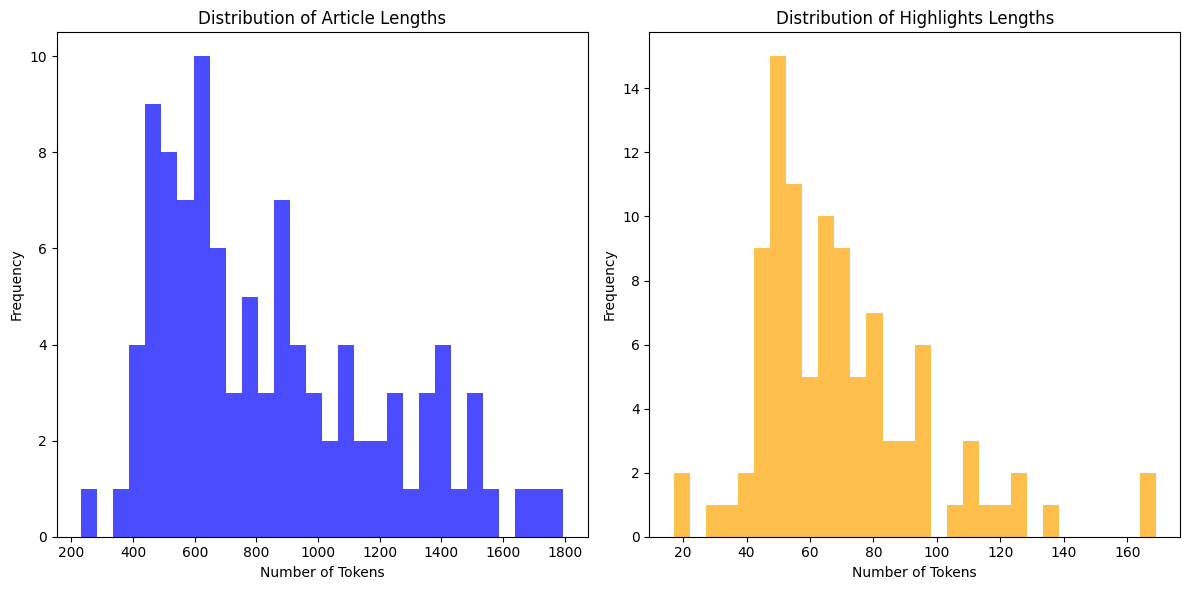

Maximum Input Length: 1796
Maximum Output Length: 169


In [ ]:
from transformers import BartTokenizerFast
from datasets import load_dataset
import matplotlib.pyplot as plt

# Instantiate the tokenizer
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-large-cnn")

# Load a sample of the CNN Dailymail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
sampled_dataset = dataset["train"].shuffle(seed=42).select([i for i in range(100)])  # Adjust the sample size as needed

# Investigate the distribution of the number of tokens
article_lengths = [len(tokenizer(article, max_length=None)["input_ids"]) for article in sampled_dataset["article"]]
highlights_lengths = [len(tokenizer(highlight, max_length=None)["input_ids"]) for highlight in sampled_dataset["highlights"]]

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(article_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(highlights_lengths, bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Highlights Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Specify maximum input and output lengths based on the investigation
max_input_length = max(max(article_lengths), max(highlights_lengths))
max_output_length = max(highlights_lengths)

print(f"Maximum Input Length: {max_input_length}")
print(f"Maximum Output Length: {max_output_length}")


## Question 2.6

Use sampled train/test/validation splits and instantiate corresponding SampleDataset to be used by the model.

In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset

# Load sampled train/test/validation splits
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_dataset = dataset["train"].shuffle(seed=42).select([i for i in range(len(dataset["train"]) // 20)])
valid_dataset = dataset["validation"].shuffle(seed=42).select([i for i in range(len(dataset["validation"]) // 20)])
test_dataset = dataset["test"].shuffle(seed=42).select([i for i in range(len(dataset["test"]) // 20)])

# Instantiate SampleDataset for training
train_sample_dataset = SampleDataset(
    tokenizer=tokenizer,
    inputs=train_dataset["article"],
    labels=train_dataset["highlights"],
    input_max_length=256,  # Adjust based on your investigation
    output_max_length=50   # Adjust based on your investigation
)

# Instantiate SampleDataset for validation
valid_sample_dataset = SampleDataset(
    tokenizer=tokenizer,
    inputs=valid_dataset["article"],
    labels=valid_dataset["highlights"],
    input_max_length=256,  # Adjust based on your investigation
    output_max_length=50   # Adjust based on your investigation
)

# Instantiate SampleDataset for testing
test_sample_dataset = SampleDataset(
    tokenizer=tokenizer,
    inputs=test_dataset["article"],
    labels=test_dataset["highlights"],
    input_max_length=256,  # Adjust based on your investigation
    output_max_length=50   # Adjust based on your investigation
)


  0%|          | 0/3 [00:00<?, ?it/s]

## Question 2.7

Use transormers' `TrainingArguments` to specify hyperparameters and parameters like output directory or logging steps.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./output",  # Specify the output directory for model checkpoints and logs
    overwrite_output_dir=True,  # Overwrite the output directory if it already exists
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size per GPU/CPU during training
    per_device_eval_batch_size=4,   # Batch size per GPU/CPU during evaluation
    save_steps=1000,  # Save a checkpoint every specified number of steps
    save_total_limit=3,  # Limit the total number of saved checkpoints
    logging_steps=500,  # Log metrics every specified number of steps
    evaluation_strategy="steps",  # Evaluate every specified number of steps
    eval_steps=1000,  # Evaluate every specified number of steps
    logging_dir="./logs",  # Specify the logging directory
    load_best_model_at_end=True,  # Load the best model at the end of training
    push_to_hub=False,  # Do not push the model to the model hub
    report_to="tensorboard",  # Enable TensorBoard logging
    run_name="generative_model_training"  # Specify a run name for easy identification
)


PyTorch: setting up devices


## Question 2.8

Fine-tune the model on the prepared dataset.

In [ ]:
model = GenerativeModel(model_name_or_path=MODEL_NAME, tokenizer=tokenizer, train_dataset=train_sample_dataset, valid_dataset=valid_sample_dataset)
model.freeze_layers()
model.train()

loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.a243ed957122436adb0b8d8e9d20f896f45c174b6324d625ca0a20a84f72a910
Model config BartConfig {
  "_name_or_path": "bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gr

Step,Training Loss
500,2.530000
1000,2.277800
1500,2.236900
2000,2.078100
2500,1.913600
3000,1.930600
3500,1.884000
4000,1.747700
4500,1.699100
5000,1.699700


Saving model checkpoint to ./output/checkpoint-500
Configuration saved in ./output/checkpoint-500/config.json
Model weights saved in ./output/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./output/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./output/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./output/checkpoint-1000
Configuration saved in ./output/checkpoint-1000/config.json
Model weights saved in ./output/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./output/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./output/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./output/checkpoint-1500
Configuration saved in ./output/checkpoint-1500/config.json
Model weights saved in ./output/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./output/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./output/checkpoint-1500/special_tokens_map.json
Sav

## Question 2.9

Explain BLEU and ROUGE metrics and explain their weaknesses. What metrics do you propose to be used to cover their problems?

****BLEU (Bilingual Evaluation Understudy):**

- **Purpose:** Evaluates machine translation.
- **Method:** Measures n-gram overlap.
- **Weaknesses:** Sensitive to variations, lacks meaning analysis.

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation):**

- **Purpose:** Evaluates summarization.
- **Method:** Measures n-gram, word overlap.
- **Weaknesses:** Favors extraction, insensitive to structure.

**Proposed Metrics:**

1. **METEOR:**
   - Considers synonymy, word order.

2. **CIDEr:**
   - Focuses on human consensus.

3. **BERTScore:**
   - Embeddings for semantic similarity.

4. **Human Evaluation:**
   - Essential for nuanced analysis.**

## Question 2.10

Complete the implementation of these metrics. using `load_metric` function of `datasets` library.

In [ ]:
from datasets import load_metric
from nltk.tokenize import word_tokenize

def compute_bleu(preds, labels, max_order):
    bleu_metric = load_metric('bleu')
    bleu_output = bleu_metric.compute(
        predictions=preds, references=labels, max_order=max_order
    )

    return bleu_output['bleu']

def compute_rouge(preds, labels, rouge_types=None):
    rouge_metric = load_metric('rouge')
    rouge_output = rouge_metric.compute(
        predictions=preds, references=labels, rouge_types=rouge_types
    )

    return rouge_output


def evaluate_generation(prediction, references):
    references = [word_tokenize(ref) for ref in references]
    prediction = [word_tokenize(pred) for pred in prediction]

    # The references for each prediction should be a list of lists.
    references = [references]

    bleu = compute_bleu([prediction], references, 1)
    rouge = compute_rouge([prediction], references, rouge_types=['rouge1', 'rouge2', 'rougeL'])

    print(f'BLEU Score: {bleu}, ROUGE Score: {rouge}')

# Example usage
prediction = ["The cat is on the mat"]
references = ["The cat is sitting on the mat", "A cat sits on the mat"]
evaluate_generation(prediction, references)


BLEU Score: 0.0, ROUGE Score: {'rouge1': AggregateScore(low=Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421), mid=Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421), high=Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421)), 'rouge2': AggregateScore(low=Score(precision=0.8, recall=0.3333333333333333, fmeasure=0.47058823529411764), mid=Score(precision=0.8, recall=0.3333333333333333, fmeasure=0.47058823529411764), high=Score(precision=0.8, recall=0.3333333333333333, fmeasure=0.47058823529411764)), 'rougeL': AggregateScore(low=Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421), mid=Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421), high=Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421))}


## Question 2.11

Report the metrics on test dataset.

In [ ]:
test_predictions, test_references = model.predict(test_sample_dataset)

# Evaluate on the test dataset
evaluate_generation(test_predictions, test_references)


100%|██████████| 144/144 [02:09<00:00,  1.11it/s]


BLEU Score: 0.0, ROUGE Score: {'rouge1': AggregateScore(low=Score(precision=0.6800785083415113, recall=0.6823552579755809, fmeasure=0.6812149808316131), mid=Score(precision=0.6800785083415113, recall=0.6823552579755809, fmeasure=0.6812149808316131), high=Score(precision=0.6800785083415113, recall=0.6823552579755809, fmeasure=0.6812149808316131)), 'rouge2': AggregateScore(low=Score(precision=0.26050255202198663, recall=0.26137482765412645, fmeasure=0.2609379608691377), mid=Score(precision=0.26050255202198663, recall=0.26137482765412645, fmeasure=0.2609379608691377), high=Score(precision=0.26050255202198663, recall=0.26137482765412645, fmeasure=0.2609379608691377)), 'rougeL': AggregateScore(low=Score(precision=0.2985279685966634, recall=0.2995273729814888, fmeasure=0.29902683574166916), mid=Score(precision=0.2985279685966634, recall=0.2995273729814888, fmeasure=0.29902683574166916), high=Score(precision=0.2985279685966634, recall=0.2995273729814888, fmeasure=0.29902683574166916))}


# Part 3. Data Augmentation


### Question 3.1

What is Data Augmentation? What are the possible methods for augmenting textual data?

**Data augmentation is a technique to diversify a training dataset by creating variations of existing data. In text, this involves applying transformations to generate new, similar samples for better model training.

######Methods:
- Synonym Replacement: Replace words with synonyms.
- Random Insertion: Add random words to the text.
- Random Deletion: Remove random words.
- Random Swap: Swap word positions randomly.
- Back Translation: Translate and then translate back for varied phrasing.
- Text Paraphrasing: Rewrite sentences while maintaining meaning.
- Text Rotation: Change word order for different sentence structures.
- Word Embedding-Based Methods: Modify word embeddings for variation.
- Contextual Word Replacement: Replace words considering context.
- Noise Injection: Introduce random noise or errors.**

### Question 3.2

Select one of the explained methods, and augment a single example using that method. Explain which libraries have you used and report the reference and augmented samples.

Let's use the "Random Insertion" method to augment our text data. This method involves inserting random words into the text. We'll use the transformers library's BartTokenizerFast to tokenize our text and the random library to insert random words.

  0%|          | 0/100 [00:00<?, ?ex/s]

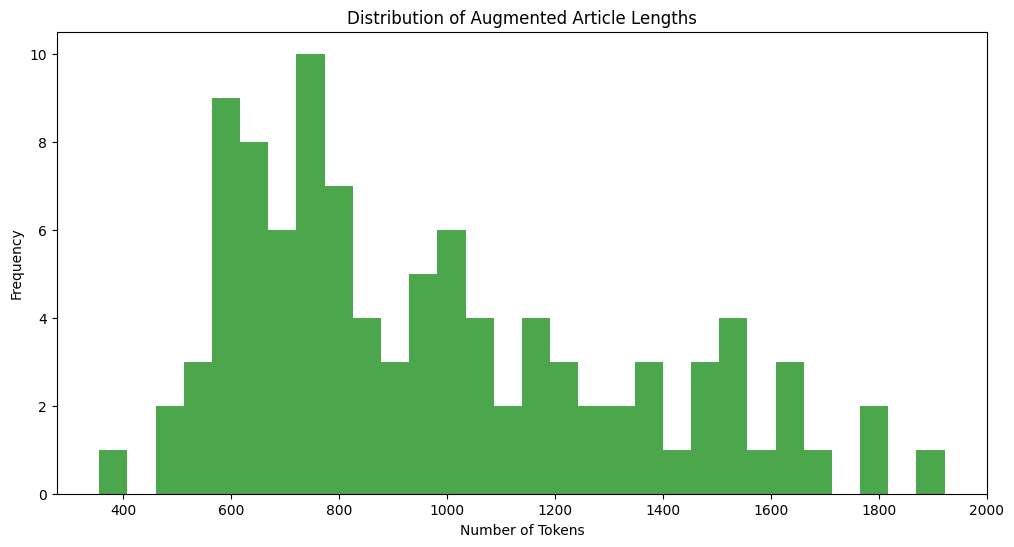

Original Samples:
Sample 1: A protester in Ferguson was arrested during a demonstration on Thursday night - and live-tweeted her entire experience. Brittany Ferrell, a nursing student at the University of Missouri-Saint Louis, was one of 13 people detained by officers in the conflicted Missouri city for 'noise disruption'. The detention has sparked an investigation by the American Civil Liberties Union as lawyers accuse officers of overstretching their powers. Scroll down for video . Arrested: This is Brittany Ferrell, the nursing student and protester who live-tweeted her arrest in Ferguson . Tweeting in handcuffs, she then took her thousands of followers through the uncertain few hours before the nine women and four men eventually learned what they had done wrong and managed to secure their release. She started with the tweet: 'We are all arrested', apparently referring to herself an other members of the advocacy group Millenial Activists United. 'Tweeting while cuffed,' she wrote, a

In [ ]:
import random
import string

def random_insertion(text, random_word_length=10, random_word_count=20):
   words = text.split()
   for _ in range(random_word_count):
       random_word = ''.join(random.choice(string.ascii_lowercase) for _ in range(random_word_length))
       random_index = random.randint(0, len(words) - 1)
       words.insert(random_index, random_word)
   return ' '.join(words)

augmented_dataset = sampled_dataset.map(lambda x: {'article': random_insertion(x['article'])})

augmented_article_lengths = [len(tokenizer(article, max_length=None)["input_ids"]) for article in augmented_dataset["article"]]

plt.figure(figsize=(12, 6))
plt.hist(augmented_article_lengths, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Augmented Article Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


# Print the first few samples from the original dataset
print("Original Samples:")
for i in range(5): # Adjust the range as needed
   print(f"Sample {i+1}: {sampled_dataset['article'][i]}")

# Print the first few samples from the augmented dataset
print("\nAugmented Samples:")
for i in range(5): # Adjust the range as needed
   print(f"Sample {i+1}: {augmented_dataset['article'][i]}")
